In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [6]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [7]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 1000       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.func1 = nn.RNNCell(self.input_size, self.hidden_size, nonlinearity='relu')
        self.func2 = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.func1(input, hidden)
        output = self.func2(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (func1): RNNCell(100, 1000, nonlinearity=relu)
  (func2): Linear(in_features=1000, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [8]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [9]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [10]:
# Number of iterations.
iters       = 12300  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
#################change optimizer ###############################
opt       = torch.optim.Adadelta(net.parameters(), lr=0.005) 
#################change optimizer ###############################
loss_func = nn.CrossEntropyLoss()

count = 0
# Training procedure.
for i in range(iters):
    try:
        input, target = get_input_and_target()            # Fetch input and target.
    except: 
        count += 1
        print("Illegal characters:")
        print(count)
        continue
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/12300 loss:13.200963020324707
\owks 3Bw,c quence: WyxMhv]F>W4_l<.#*,
Pm$ lg,,,LWit a4  eF ni-en anDkoRsrCts,careSp,l  'vS e r t v gRr  ,

iter:199/12300 loss:3.577272653579712
generated sequence: W.Ol7'p>WahU e2c,;O=ox<Roka0e   )a]ypr  K ac,sWotJcVgKwetsGhkh kethdWstEh 
\ lsusbieevd t Tni tmboat 

iter:299/12300 loss:3.445704221725464
generated sequence: W;.I;m^!EjkWf'ts0hOc9s rCbPSw d kyEeak.eno
r
lSn ptn
as
st hAcratoyoetgfrA$nwete tS d.aeen d olS welo

iter:399/12300 loss:3.3788347244262695
generated sequence: W_'dySSnp  ;iodt,hyai Mf:a
eb,ms k r!yndtt eioyesvhYtrisdrWSakesslhna:ia
hcwQs.ua :eD l  utA
Chsmicbi

iter:499/12300 loss:3.371117115020752
generated sequence: W]6LlphI' igAey ,Iou hy v ohohJshStiatdape:tv crrguae
n.hsT gtr
 sm huhilt tue aus 'eoadytd
WouoEuft'

iter:599/12300 loss:3.360095500946045
generated sequence: WkOGch4rxEheenoiecaareefutpbNodde ticlowautaa towu sH t  wi  reyhshNohn  n,doeloem atAt nsm eeemsorny

iter:699/12300 loss:3.3305537700653076
generat

#### Training Loss Curve

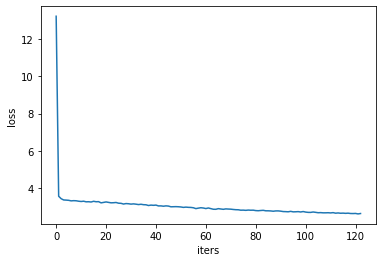

In [11]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [12]:
all_losses

[tensor(13.2010, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.5773, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4457, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3788, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3711, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3601, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3306, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3409, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3352, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3122, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.2969, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3116, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.2797, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.2840, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.2692, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3074, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.2832, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.288

#### Evaluation: A Sample of Generated Sequence

In [13]:
print(eval_step(net, predicted_len=600))

WHr nmmeA dndban os seme vedpt howe dwdrl tns seryor cfundrt
l nokewr mafthrd ly mel asu trerhbwwstt sor steolainaf aho nrala ;eees hara cs th.

ReOdRB,U: yss tfiuc aml te dssthea ko blur se mxrD
GoRLTU:Ede lold ni;we shl lie lhe


AV!nSAr :ouha t lenarT mnunH ,nss he aian wpoely.

Wtm;: wo hes noss ro mhrll?rr
Ge aa.eM

iwe sn ward boal,.
oui ntfds as tit, fit sorlklcra ke itgen ld yale rr.LMEGpTIhEUTmNa: Yo thala g;rn, mdebhad h. ganb mem yo ingthirtms noa kivll
,o,fWw ths ,oms ;hsl au mhd m?dcbkedg, cordy ors eyna inrdustpes,
Bo u..
!y,AUI
:uAos fostthan po ar heHes
ir Rha lanf urpi
uy ie mn


In [14]:
import numpy as np
f = open("original_RNN_1000.npy", "w")

In [15]:
a = [data.item() for data in all_losses]

In [16]:
a

[13.200963020324707,
 3.577272653579712,
 3.445704221725464,
 3.3788347244262695,
 3.371117115020752,
 3.360095500946045,
 3.3305537700653076,
 3.340928077697754,
 3.335222005844116,
 3.3121821880340576,
 3.2969231605529785,
 3.31162691116333,
 3.2796788215637207,
 3.284001588821411,
 3.2692315578460693,
 3.307384490966797,
 3.2831501960754395,
 3.2885959148406982,
 3.2238857746124268,
 3.2481091022491455,
 3.2726399898529053,
 3.248987913131714,
 3.2255687713623047,
 3.231229066848755,
 3.2438266277313232,
 3.206028699874878,
 3.1983392238616943,
 3.160357713699341,
 3.1855874061584473,
 3.1761670112609863,
 3.155827760696411,
 3.169165849685669,
 3.153045654296875,
 3.1322412490844727,
 3.14886474609375,
 3.1259267330169678,
 3.1204335689544678,
 3.0816640853881836,
 3.104013681411743,
 3.092296600341797,
 3.104337692260742,
 3.059535503387451,
 3.0620758533477783,
 3.0443174839019775,
 3.0627517700195312,
 3.051968812942505,
 3.0131208896636963,
 3.0174319744110107,
 3.0212318897247

In [17]:
np.save("original_RNN_1000.npy", a)

In [18]:
np.load("original_RNN_1000.npy")

array([13.20096302,  3.57727265,  3.44570422,  3.37883472,  3.37111712,
        3.3600955 ,  3.33055377,  3.34092808,  3.33522201,  3.31218219,
        3.29692316,  3.31162691,  3.27967882,  3.28400159,  3.26923156,
        3.30738449,  3.2831502 ,  3.28859591,  3.22388577,  3.2481091 ,
        3.27263999,  3.24898791,  3.22556877,  3.23122907,  3.24382663,
        3.2060287 ,  3.19833922,  3.16035771,  3.18558741,  3.17616701,
        3.15582776,  3.16916585,  3.15304565,  3.13224125,  3.14886475,
        3.12592673,  3.12043357,  3.08166409,  3.10401368,  3.0922966 ,
        3.10433769,  3.0595355 ,  3.06207585,  3.04431748,  3.06275177,
        3.05196881,  3.01312089,  3.01743197,  3.02123189,  3.01511431,
        3.0036211 ,  2.98138785,  2.99597478,  2.984056  ,  2.97898269,
        2.96137571,  2.91612673,  2.94160366,  2.96279407,  2.94821548,
        2.91879082,  2.95000339,  2.91521382,  2.88189626,  2.87982273,
        2.91439319,  2.89551926,  2.87884188,  2.90100884,  2.89

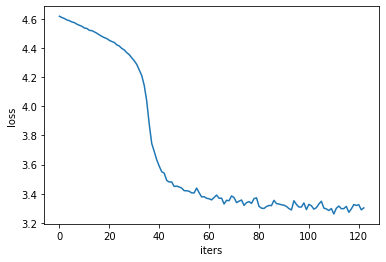

In [30]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("original_RNN_1000.npy"))
plt.show()

In [31]:
## experiment different plotting

In [32]:
a = np.random.choice(100, 100)
b = np.random.choice(100, 100)
y = np.arange(100) #length of the loss

ValueError: Cannot load file containing pickled data when allow_pickle=False

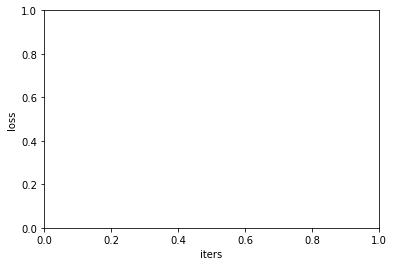

In [33]:
import numpy as np
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("original_RNN.npy"), label='RNN(Relu-100)')
plt.plot(np.load("original_RNN_tanh.npy"), label='RNN(tanh)')
plt.plot(np.load("original_RNN_10.npy"), label='RNN(Relu-10)')
plt.legend(loc='best')
plt.show()